# Импорты библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Чтение данных

In [16]:
data_path = Path("data/app_survey.csv")
df = pd.read_csv(data_path, parse_dates=["survey_creation_dt", "survey_response_dt"])

print(f"Данные загружены из {data_path}")
print(f"Размерность данных: {df.shape}")
print(f"Количество строк: {df.shape[0]:,}")
print(f"Количество столбцов: {df.shape[1]}")

df.head()

Данные загружены из data\app_survey.csv
Размерность данных: (42387, 9)
Количество строк: 42,387
Количество столбцов: 9


,user_id,survey_creation_dt,survey_response_dt,csat_level,language,age,gender,tenure_years,user_income
0,user_00000,2025-04-28 16:01:51,2025-05-07 03:24:28,1,RU,35-44,M,21.105392,10000-25000
1,user_00001,2025-04-25 03:02:23,2025-04-29 13:12:29,5,RU,35-44,M,21.129793,68000-100000
2,user_00002,2025-04-30 11:02:14,2025-04-20 21:09:01,5,RU,45-54,M,21.098074,NaN
3,user_00003,2025-04-25 09:32:18,2025-04-26 19:51:12,5,RU,45-54,M,21.115544,25000-44000
4,user_00004,2025-04-30 08:32:06,2025-05-01 18:33:35,5,RU,45-54,M,21.127961,44000-68000


# Первичный анализ данных

             Количество пропусков  Процент пропусков
user_income                 10374          24.474485
language                     6826          16.103994
age                          1448           3.416142


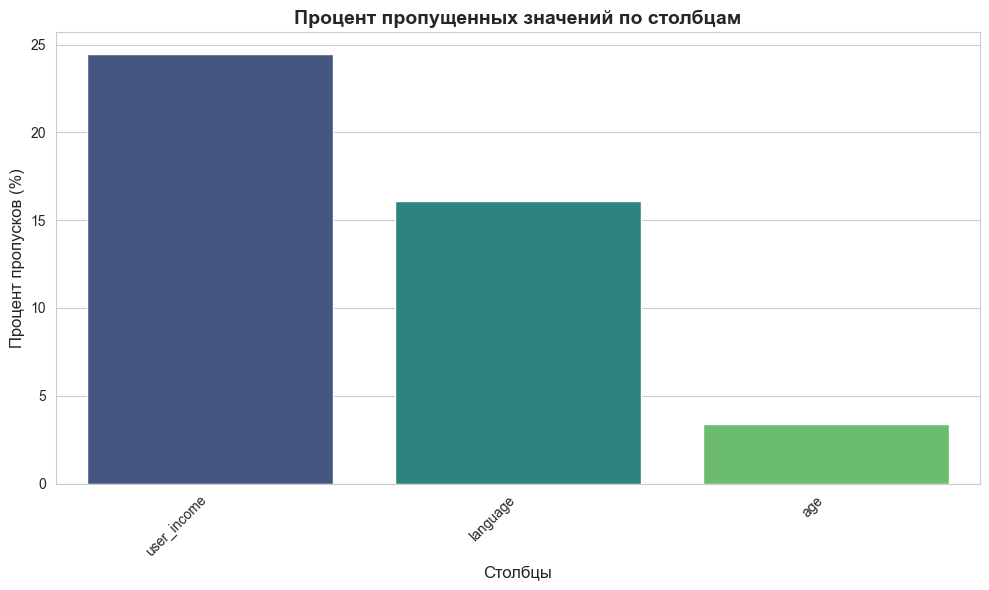


Общее количество пропущенных значений: 18648


In [17]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame(
    {"Количество пропусков": missing_values, "Процент пропусков": missing_percent}
)
missing_df = missing_df[missing_df["Количество пропусков"] > 0].sort_values(
    "Количество пропусков", ascending=False
)

if len(missing_df) > 0:
    print(missing_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=missing_df.reset_index(),
        x="index",
        y="Процент пропусков",
        hue="index",
        palette="viridis",
        legend=False,
    )
    plt.title(
        "Процент пропущенных значений по столбцам", fontsize=14, fontweight="bold"
    )
    plt.xlabel("Столбцы", fontsize=12)
    plt.ylabel("Процент пропусков (%)", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    print(f"\nОбщее количество пропущенных значений: {df.isnull().sum().sum()}")
else:
    print("Пропущенных значений не обнаружено")


## Описательная статистика


In [18]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if numeric_cols:
    print(df[numeric_cols].describe())

exclude_cols = ["user_id", "survey_creation_dt", "survey_response_dt"]
categorical_cols = [
    col
    for col in df.select_dtypes(include=["object"]).columns
    if col not in exclude_cols
]

for col in categorical_cols:
    print(f"\n{col}:")
    print(f"  Уникальных значений: {df[col].nunique()}")
    print(f"  Топ-5 значений:")
    print(df[col].value_counts().head())


         csat_level  tenure_years
count  42387.000000  42387.000000
mean       4.102767      9.801147
std        1.506246      7.591410
min        1.000000      0.000000
25%        4.000000      2.132807
50%        5.000000      9.308819
75%        5.000000     16.941052
max        5.000000     21.195642

language:
  Уникальных значений: 1
  Топ-5 значений:
language
RU    35561
Name: count, dtype: int64

age:
  Уникальных значений: 5
  Топ-5 значений:
age
35-44    11835
25-34     9669
45-54     9483
55-65     6312
18-24     3640
Name: count, dtype: int64

gender:
  Уникальных значений: 2
  Топ-5 значений:
gender
M    32413
F     9974
Name: count, dtype: int64

user_income:
  Уникальных значений: 6
  Топ-5 значений:
user_income
10000-25000     18354
25000-44000      6206
>100000          2418
44000-68000      2095
68000-100000     1641
Name: count, dtype: int64


## Анализ целевой переменной


csat_level
1     6732
2     1187
3     2175
4     3192
5    29101
Name: count, dtype: int64

Средняя оценка: 4.10
Медианная оценка: 5.00


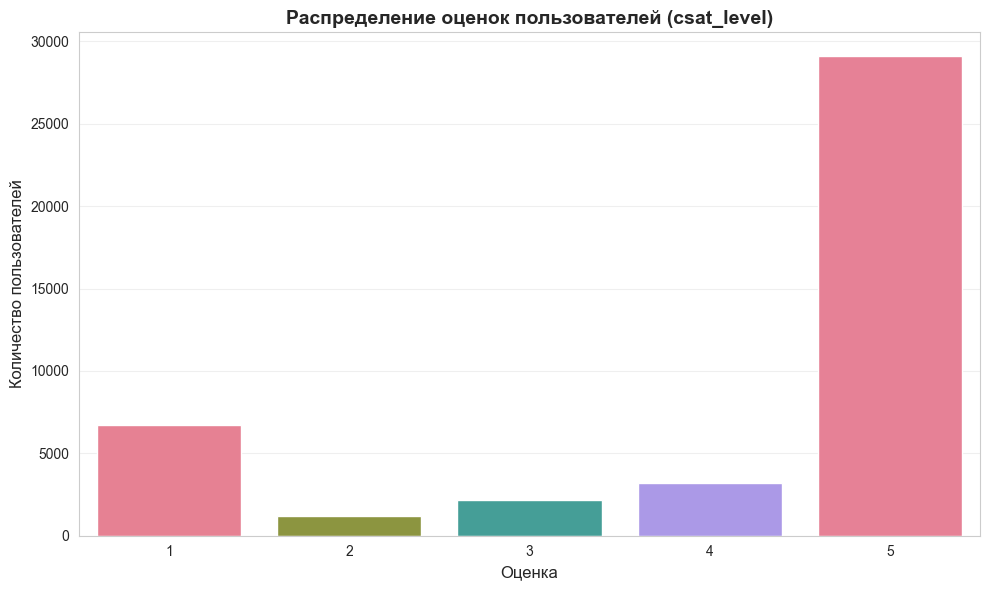

In [19]:
print(df["csat_level"].value_counts().sort_index())
print(f"\nСредняя оценка: {df['csat_level'].mean():.2f}")
print(f"Медианная оценка: {df['csat_level'].median():.2f}")

plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x="csat_level",
    hue="csat_level",
    palette="husl",
    order=sorted(df["csat_level"].unique()),
    legend=False,
)
plt.title(
    "Распределение оценок пользователей (csat_level)", fontsize=14, fontweight="bold"
)
plt.xlabel("Оценка", fontsize=12)
plt.ylabel("Количество пользователей", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## Проверка дубликатов и уникальности


In [20]:
duplicates = df.duplicated().sum()
print(f"Количество полных дубликатов строк: {duplicates}")

print(f"\nВсего записей: {len(df)}")
print(f"Уникальных user_id: {df['user_id'].nunique()}")
print(f"Дубликатов user_id: {df['user_id'].duplicated().sum()}")


Количество полных дубликатов строк: 0

Всего записей: 42387
Уникальных user_id: 40065
Дубликатов user_id: 2322


## Проверка дат и времени ответа


In [21]:
invalid_dates = (df["survey_response_dt"] < df["survey_creation_dt"]).sum()
print(f"Записей с датой ответа раньше даты создания: {invalid_dates}")

df["response_time_days"] = (
    df["survey_response_dt"] - df["survey_creation_dt"]
).dt.total_seconds() / (24 * 3600)
print(f"\nСтатистика времени ответа (дни):")
print(df["response_time_days"].describe())

negative_response_time = (df["response_time_days"] < 0).sum()
print(f"\nЗаписей с отрицательным временем ответа: {negative_response_time}")


Записей с датой ответа раньше даты создания: 18400

Статистика времени ответа (дни):
count    42387.000000
mean         1.446449
std          8.750098
min        -19.582558
25%         -4.581620
50%          1.421250
75%          7.492581
max         31.215660
Name: response_time_days, dtype: float64

Записей с отрицательным временем ответа: 18400


## Выбросы


In [22]:
Q1 = df["tenure_years"].quantile(0.25)
Q3 = df["tenure_years"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = (
    (df["tenure_years"] < lower_bound) | (df["tenure_years"] > upper_bound)
).sum()
print(f"Выбросы в tenure_years (метод IQR): {outliers}")
print(f"  Границы: [{lower_bound:.2f}, {upper_bound:.2f}]")


Выбросы в tenure_years (метод IQR): 0
  Границы: [-20.08, 39.15]


## Анализ по месяцам


Распределение оценок по месяцам:
            count      mean  median       std
month_name                                   
Апрель      13915  4.079770     5.0  1.523272
Май         28472  4.114007     5.0  1.497753

Разница средних оценок (Май - Апрель): 0.034

Апрель (месяц 4):
  Количество записей: 13915
  Средняя оценка: 4.080
  Медианная оценка: 5.00
  Распределение (%):
    1: 16.4%
    2: 2.9%
    3: 5.1%
    4: 7.5%
    5: 68.1%

Май (месяц 5):
  Количество записей: 28472
  Средняя оценка: 4.114
  Медианная оценка: 5.00
  Распределение (%):
    1: 15.6%
    2: 2.8%
    3: 5.2%
    4: 7.6%
    5: 68.9%


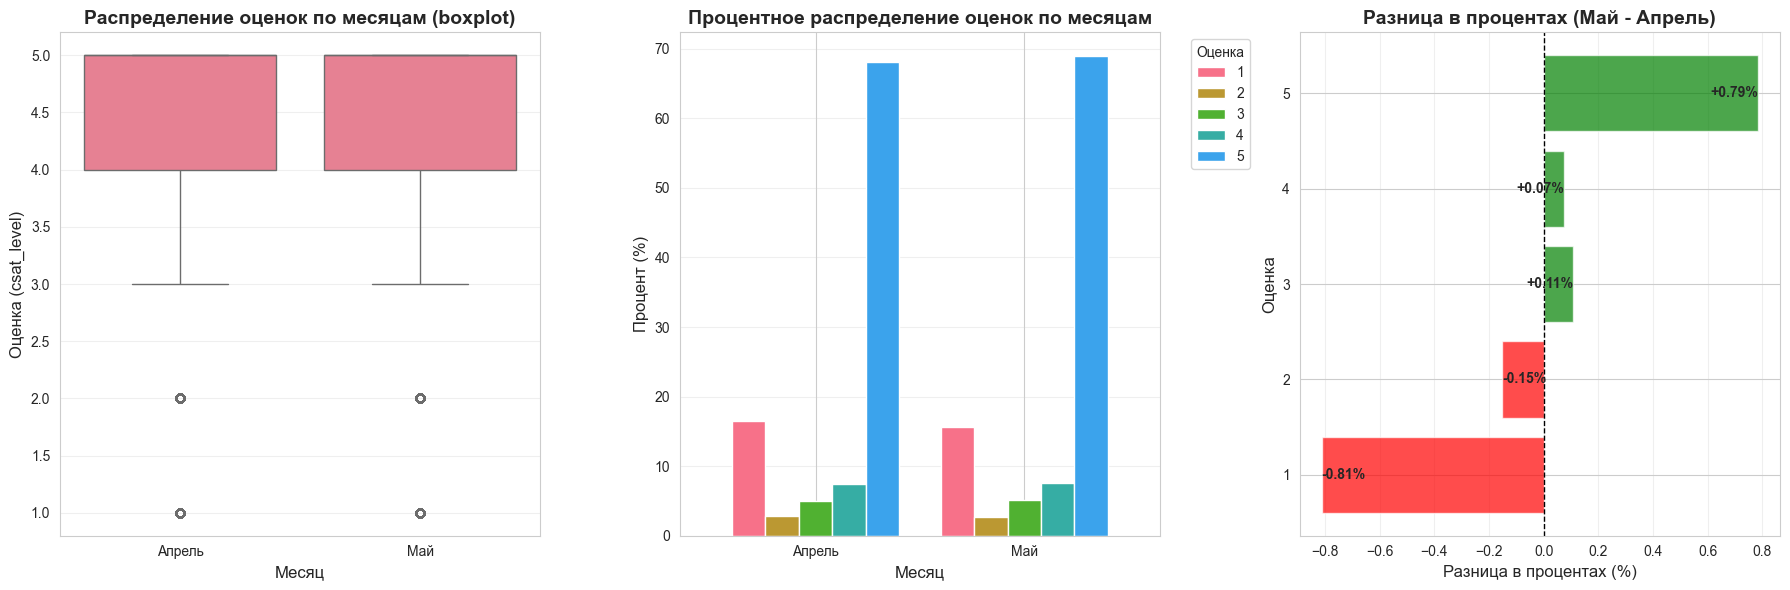

In [23]:
df["creation_month"] = df["survey_creation_dt"].dt.month
month_names = {4: "Апрель", 5: "Май"}
df["month_name"] = df["creation_month"].map(month_names)

print(f"Распределение оценок по месяцам:")
month_stats = df.groupby("month_name")["csat_level"].agg(
    ["count", "mean", "median", "std"]
)
print(month_stats)

april_data = df[df["creation_month"] == 4]["csat_level"]
may_data = df[df["creation_month"] == 5]["csat_level"]
diff_mean = may_data.mean() - april_data.mean()
print(f"\nРазница средних оценок (Май - Апрель): {diff_mean:.3f}")

for month in [4, 5]:
    month_data = df[df["creation_month"] == month]["csat_level"]
    month_name = month_names[month]
    print(f"\n{month_name} (месяц {month}):")
    print(f"  Количество записей: {len(month_data)}")
    print(f"  Средняя оценка: {month_data.mean():.3f}")
    print(f"  Медианная оценка: {month_data.median():.2f}")
    print(f"  Распределение (%):")
    month_pct = month_data.value_counts(normalize=True).sort_index() * 100
    for score, pct in month_pct.items():
        print(f"    {score}: {pct:.1f}%")

month_dist = pd.crosstab(df["month_name"], df["csat_level"], normalize="index") * 100

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(
    data=df, x="month_name", y="csat_level", order=["Апрель", "Май"], ax=axes[0]
)
axes[0].set_title(
    "Распределение оценок по месяцам (boxplot)", fontsize=14, fontweight="bold"
)
axes[0].set_xlabel("Месяц", fontsize=12)
axes[0].set_ylabel("Оценка (csat_level)", fontsize=12)
axes[0].grid(axis="y", alpha=0.3)

month_dist.plot(kind="bar", ax=axes[1], width=0.8)
axes[1].set_title(
    "Процентное распределение оценок по месяцам", fontsize=14, fontweight="bold"
)
axes[1].set_xlabel("Месяц", fontsize=12)
axes[1].set_ylabel("Процент (%)", fontsize=12)
axes[1].legend(title="Оценка", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[1].grid(axis="y", alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

diff_pct = month_dist.loc["Май"] - month_dist.loc["Апрель"]
colors = ["red" if x < 0 else "green" for x in diff_pct.values]
axes[2].barh(range(len(diff_pct)), diff_pct.values, color=colors, alpha=0.7)
axes[2].set_yticks(range(len(diff_pct)))
axes[2].set_yticklabels(diff_pct.index)
axes[2].axvline(x=0, color="black", linestyle="--", linewidth=1)
axes[2].set_title("Разница в процентах (Май - Апрель)", fontsize=14, fontweight="bold")
axes[2].set_xlabel("Разница в процентах (%)", fontsize=12)
axes[2].set_ylabel("Оценка", fontsize=12)
axes[2].grid(axis="x", alpha=0.3)
for i, (score, diff) in enumerate(diff_pct.items()):
    axes[2].text(
        diff,
        i,
        f"{diff:+.2f}%",
        va="center",
        ha="left" if diff < 0 else "right",
        fontweight="bold",
        fontsize=10,
    )

plt.tight_layout()
plt.show()


## Анализ по полу


Распределение оценок по полу:
        count      mean  median
gender                         
F        9974  4.050732     5.0
M       32413  4.118780     5.0

Доля по полу:
  M: 76.5%
  F: 23.5%

Мужчины (M):
  Количество записей: 32413
  Средняя оценка: 4.12
  Медианная оценка: 5.00
  Распределение:
csat_level
1     5012
2      911
3     1658
4     2466
5    22366
Name: count, dtype: int64

Женщины (F):
  Количество записей: 9974
  Средняя оценка: 4.05
  Медианная оценка: 5.00
  Распределение:
csat_level
1    1720
2     276
3     517
4     726
5    6735
Name: count, dtype: int64


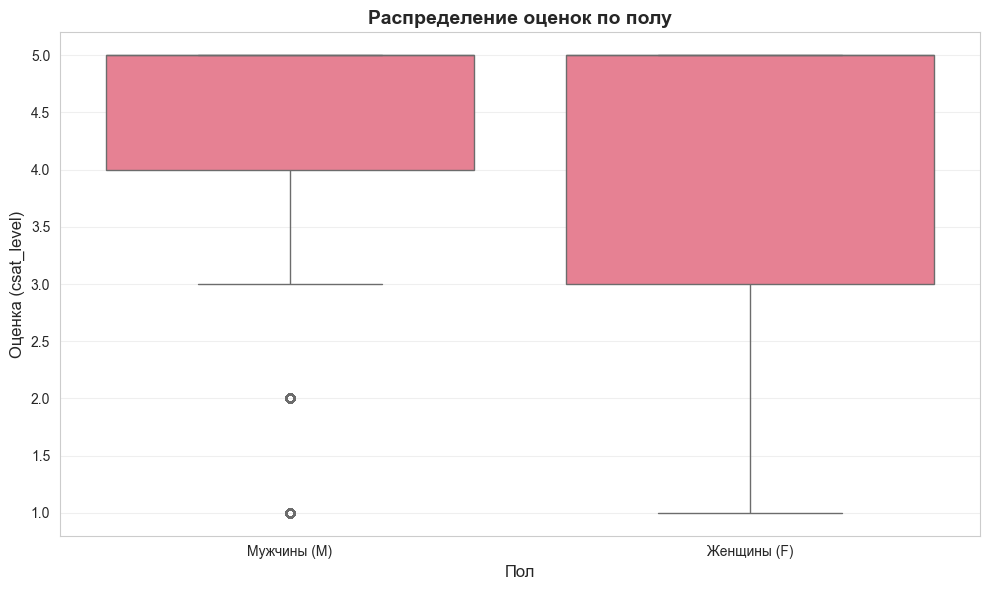

In [24]:
print(f"Распределение оценок по полу:")
gender_stats = df.groupby("gender")["csat_level"].agg(["count", "mean", "median"])
gender_pct = df["gender"].value_counts(normalize=True) * 100
print(gender_stats)
print(f"\nДоля по полу:")
for gender, pct in gender_pct.items():
    print(f"  {gender}: {pct:.1f}%")

for gender in ["M", "F"]:
    gender_data = df[df["gender"] == gender]["csat_level"]
    gender_name = "Мужчины" if gender == "M" else "Женщины"
    print(f"\n{gender_name} ({gender}):")
    print(f"  Количество записей: {len(gender_data)}")
    print(f"  Средняя оценка: {gender_data.mean():.2f}")
    print(f"  Медианная оценка: {gender_data.median():.2f}")
    print(f"  Распределение:")
    print(gender_data.value_counts().sort_index())

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="gender", y="csat_level", order=["M", "F"])
plt.title("Распределение оценок по полу", fontsize=14, fontweight="bold")
plt.xlabel("Пол", fontsize=12)
plt.ylabel("Оценка (csat_level)", fontsize=12)
plt.xticks([0, 1], ["Мужчины (M)", "Женщины (F)"])
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# Проверить гистограмму отрицательных responce_time_days

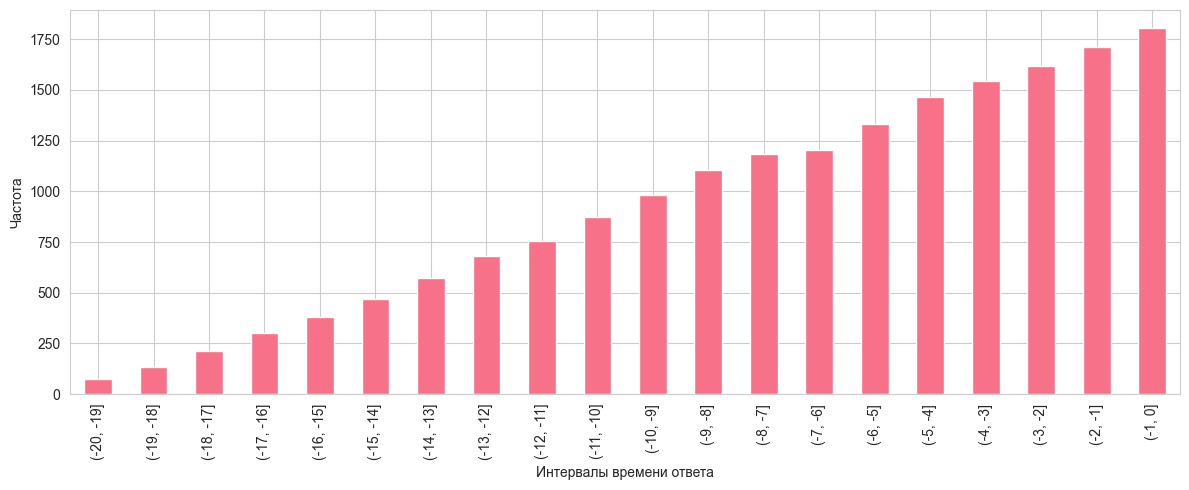

In [25]:


df_not_clean = df[df["response_time_days"] < 0].copy()
bins = np.arange(-20, 0+1, 1)
binned = pd.cut(df_not_clean["response_time_days"], bins=bins)
freq = binned.value_counts().sort_index()
ax = freq.plot(kind="bar", figsize=(12, 5))
ax.set_xlabel("Интервалы времени ответа")
ax.set_ylabel("Частота")
plt.tight_layout()
plt.show()



# Проверить всю гистограмму responce_time_days

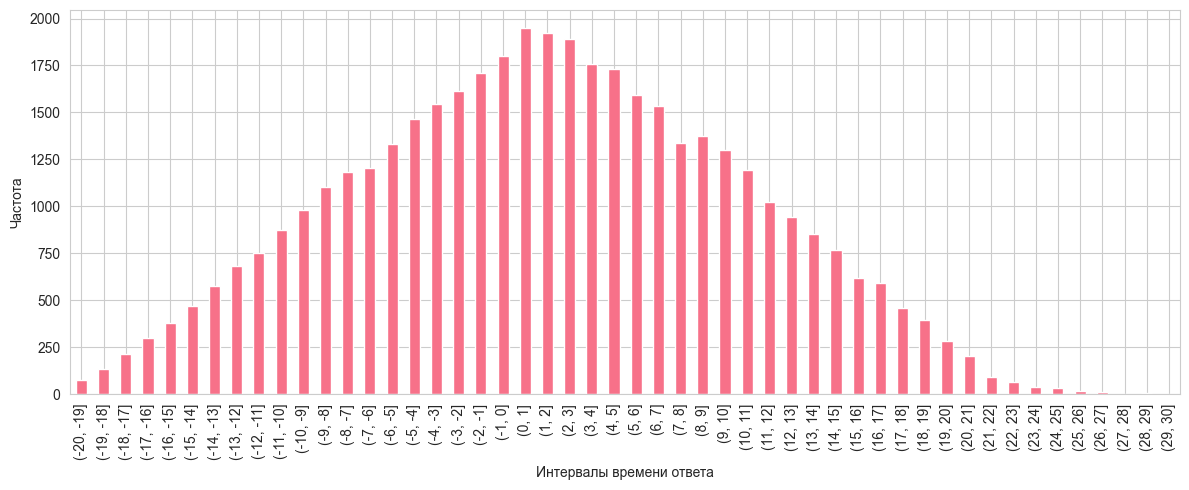

In [12]:
df_2= df.copy()

bins = np.arange(-20, 30 + 1, 1)
binned = pd.cut(df_2["response_time_days"], bins=bins)

freq = binned.value_counts().sort_index()

ax = freq.plot(kind="bar", figsize=(12, 5))
ax.set_xlabel("Интервалы времени ответа")
ax.set_ylabel("Частота")
plt.tight_layout()
plt.show()


# Создание признака возраст + пол


 Было: 42387, стало: 40939


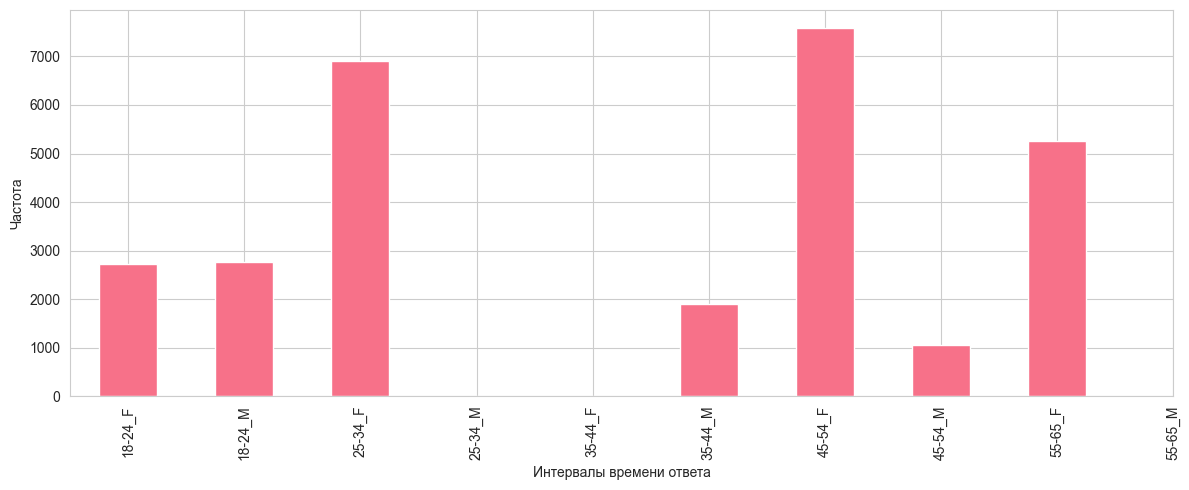

age_gender_encoded
(1, 2]     2720
(2, 3]     2769
(3, 4]     6900
(4, 5]        0
(5, 6]        0
(6, 7]     1904
(7, 8]     7579
(8, 9]     1050
(9, 10]    5262
Name: count, dtype: int64


In [ ]:
df_2= df.copy()
df_2['age_gender'] = df_2['age'] + "_" + df_2['gender']
df_2.sort_values(by='age_gender', inplace=True)
df_2.describe(include="object")


age_gender_dict = {
    "18-24_F" : 1, 
    "18-24_M" : 2,
    "25-34_F" : 3, 
    "25-34_M" : 4,   
    "35-54_F" : 5, 
    "35-54_M" : 6,    
    "45-54_F" : 7, 
    "45-54_M" : 8,
    "55-65_F" : 9, 
    "55-65_M" : 10        
    }

labels = [
    "18-24_F", "18-24_M",
    "25-34_F", "25-34_M",
    "35-44_F", "35-44_M",
    "45-54_F", "45-54_M",
    "55-65_F", "55-65_M",
]

length_df2_before = len(df_2)
df_2.dropna(subset=["age_gender"], inplace=True)
length_df2_afrer = len(df_2)
print(f"\n Было: {length_df2_before}, стало: {length_df2_afrer}")

df_2["age_gender_encoded"] = df_2["age_gender"].map(age_gender_dict)




bins = np.arange(1, 10 + 1, 1)
binned = pd.cut(df_2["age_gender_encoded"], bins=bins)


freq = binned.value_counts().sort_index()

ax = freq.plot(kind="bar", figsize=(12, 5))
ax.set_xlabel("Интервалы времени ответа")
ax.set_ylabel("Частота")
ax.set_xticks(range(0, len(labels)))
ax.set_xticklabels(labels)
plt.tight_layout()
plt.show()


####Тут какая-то ошибка у меня в выводе

csat_level     1    2    3    4     5
age_gender                           
18-24_F      158   35   57   67   603
18-24_M      557   89  185  170  1719
25-34_F      536   68  143  188  1834
25-34_M     1198  185  355  518  4644
35-44_F      507   80  168  234  2123
35-44_M     1288  211  446  606  6172
45-54_F      307   57   89  134  1317
45-54_M     1092  226  360  598  5303
55-65_F      160   34   49   86   721
55-65_M      721  164  241  440  3696


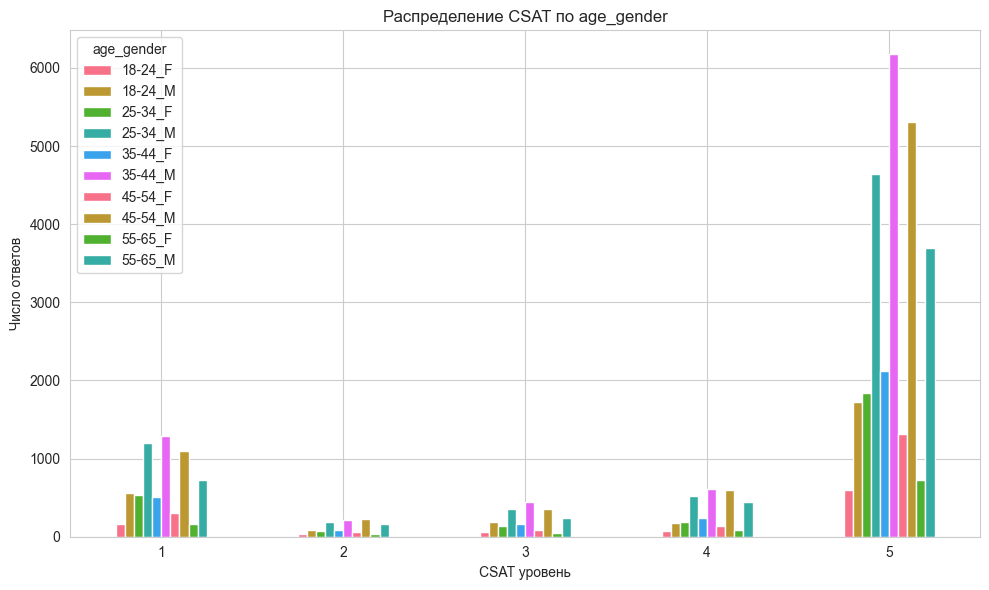

In [41]:
csat_freq = (
df_2
.groupby('age_gender')['csat_level']
.value_counts()
.unstack(fill_value=0)
)


print(csat_freq)

ax = csat_freq.T.plot(
    kind='bar', figsize=(10, 6)
)
ax.set_xlabel('CSAT уровень')
ax.set_ylabel('Число ответов')
ax.set_title('Распределение CSAT по age_gender')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


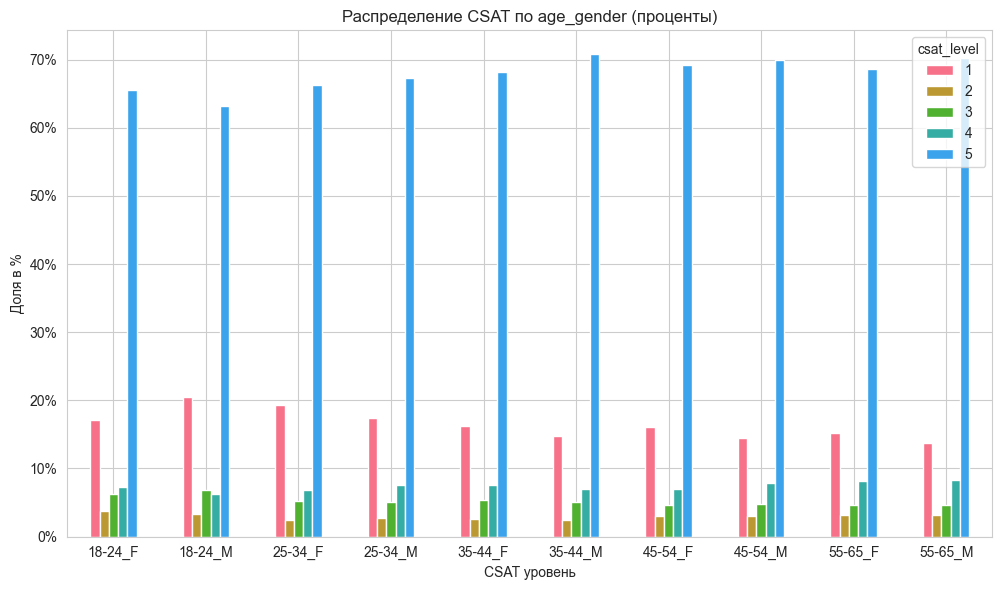

In [44]:
# 1. Группируем по age_gender и считаем частоты csat_level
csat_counts = (
    df_2
    .groupby('age_gender')['csat_level']
    .value_counts()          # счётчик 1..5 в каждой группе
    .unstack(fill_value=0)   # столбцы = 1..5
)

# 2. (опционально) перевести в проценты по каждой группе
csat_pct = csat_counts.div(csat_counts.sum(axis=1), axis=0) * 100
ax = csat_pct.plot(
    kind='bar',
    figsize=(10, 6)
)
ax.set_xlabel('CSAT уровень')
ax.set_ylabel('Доля в %')
ax.set_title('Распределение CSAT по age_gender (проценты)')
plt.xticks(rotation=0)
plt.tight_layout()

# Если хочешь, чтобы шкала Y была в процентах c "%"
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter())


# Очистка данных


In [14]:
initial_rows = len(df)
print(f"Исходное количество строк: {initial_rows:,}")

df_clean = df[df["response_time_days"] >= 0].copy()
rows_removed_dates = initial_rows - len(df_clean)
print(f"Удалено записей с некорректными датами: {rows_removed_dates}")

language_missing_before = df_clean["language"].isnull().sum()
if language_missing_before > 0:
    df_clean["language"] = df_clean["language"].fillna("RU")
    print(f"Заполнено пропусков в language: {language_missing_before} -> 0")

print(f"Пропуски в age остаются: {df_clean['age'].isnull().sum()}")
print(f"Пропуски в user_income остаются: {df_clean['user_income'].isnull().sum()}")

duplicates_before = df_clean.duplicated().sum()
df_clean = df_clean.drop_duplicates()
if duplicates_before > 0:
    print(f"Удалено полных дубликатов: {duplicates_before}")

print(f"\nИсходное количество строк: {initial_rows:,}")
print(f"Финальное количество строк: {len(df_clean):,}")
print(f"Удалено строк: {initial_rows - len(df_clean):,}")
print(f"Процент сохраненных данных: {len(df_clean) / initial_rows * 100:.2f}%")

df = df_clean.copy()


Исходное количество строк: 42,387
Удалено записей с некорректными датами: 18400
Заполнено пропусков в language: 3854 -> 0
Пропуски в age остаются: 846
Пропуски в user_income остаются: 5916

Исходное количество строк: 42,387
Финальное количество строк: 23,987
Удалено строк: 18,400
Процент сохраненных данных: 56.59%


# Корреляционный анализ для обоснования гипотез


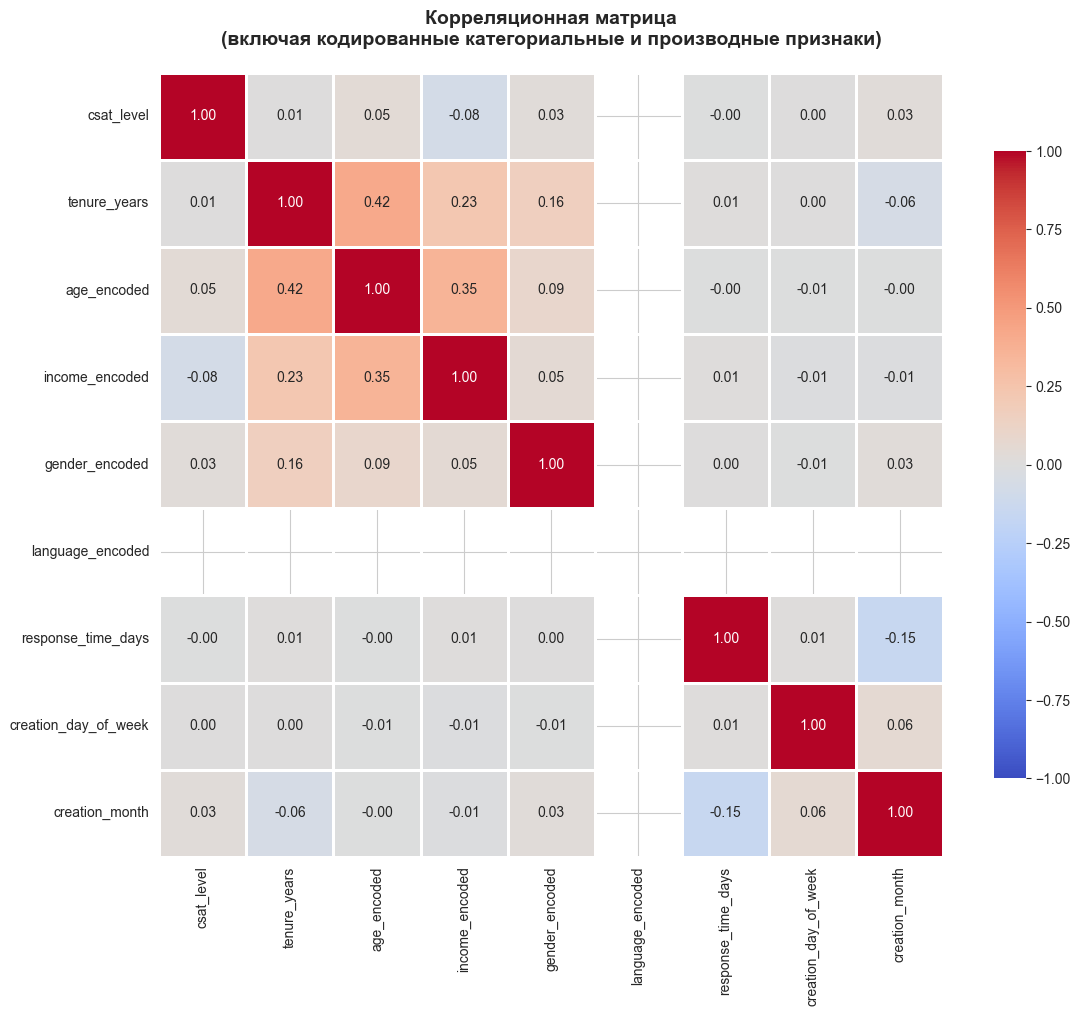


Корреляция с целевой переменной (csat_level):
age_encoded              :  0.046
gender_encoded           :  0.027
creation_month           :  0.027
tenure_years             :  0.008
creation_day_of_week     :  0.002
response_time_days       : -0.003
income_encoded           : -0.076
language_encoded         :    nan


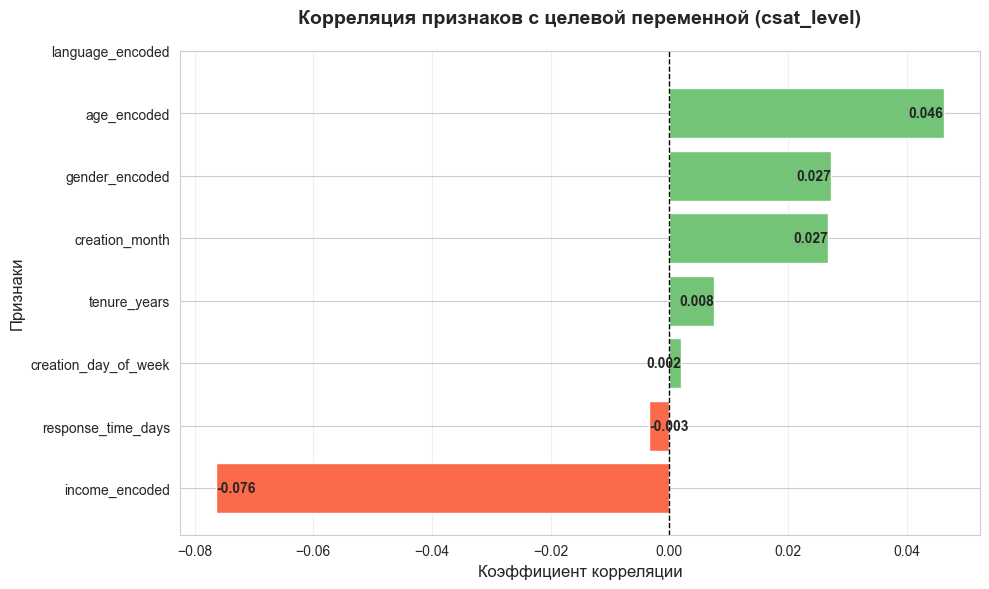

In [15]:
df_corr = df.copy()

age_mapping = {
    "<18": 0,
    "18-24": 1,
    "25-34": 2,
    "35-44": 3,
    "45-54": 4,
    "55-65": 5,
    ">65": 6,
}
df_corr["age_encoded"] = df_corr["age"].map(age_mapping)

income_mapping = {
    "<10000": 1,
    "10000-25000": 2,
    "25000-44000": 3,
    "44000-68000": 4,
    "68000-100000": 5,
    ">100000": 6,
}
df_corr["income_encoded"] = df_corr["user_income"].map(income_mapping)

df_corr["gender_encoded"] = df_corr["gender"].map({"M": 1, "F": 0})

df_corr["language_encoded"] = (df_corr["language"] == "RU").astype(int)

df_corr["creation_day_of_week"] = df_corr["survey_creation_dt"].dt.dayofweek
df_corr["creation_month"] = df_corr["survey_creation_dt"].dt.month

corr_cols = [
    "csat_level",
    "tenure_years",
    "age_encoded",
    "income_encoded",
    "gender_encoded",
    "language_encoded",
    "response_time_days",
    "creation_day_of_week",
    "creation_month",
]

corr_matrix = df_corr[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    vmin=-1,
    vmax=1,
)
plt.title(
    "Корреляционная матрица\n(включая кодированные категориальные и производные признаки)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.tight_layout()
plt.show()

print("\nКорреляция с целевой переменной (csat_level):")
csat_corr = corr_matrix["csat_level"].sort_values(ascending=False)
for col, corr_val in csat_corr.items():
    if col != "csat_level":
        print(f"{col:25s}: {corr_val:6.3f}")

csat_correlations = (
    corr_matrix["csat_level"].drop("csat_level").sort_values(ascending=True)
)

plt.figure(figsize=(10, 6))
red_color = sns.color_palette("Reds_r", 1)[0]
green_color = sns.color_palette("Greens", 1)[0]
colors = [red_color if x < 0 else green_color for x in csat_correlations.values]

plt.barh(range(len(csat_correlations)), csat_correlations.values, color=colors)
plt.yticks(range(len(csat_correlations)), csat_correlations.index)
plt.axvline(x=0, color="black", linestyle="--", linewidth=1)
plt.title(
    "Корреляция признаков с целевой переменной (csat_level)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
plt.xlabel("Коэффициент корреляции", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.grid(axis="x", alpha=0.3)

for i, (idx, val) in enumerate(csat_correlations.items()):
    plt.text(
        val,
        i,
        f"{val:.3f}",
        va="center",
        ha="left" if val < 0 else "right",
        fontweight="bold",
    )

plt.tight_layout()
plt.show()


# Гипотезы

### Гипотеза 1: Отрицательная связь дохода с оценкой

**Формулировка:** Пользователи с более высоким доходом дают более низкие оценки.

**Обоснование:** r = -0.076 (самая сильная по модулю корреляция). Пропуски в доходе: 24.47%.

### Гипотеза 2: Положительная связь возраста с оценкой

**Формулировка:** Более старшие возрастные группы дают более высокие оценки.

**Обоснование:** r = 0.046 (наибольшая положительная корреляция). Распределение: 35-44 (11835), 25-34 (9669), 45-54 (9483).



### Гипотеза 3: Мужчины дают более высокие оценки, чем женщины

**Формулировка:** Мужчины дают более высокие оценки удовлетворенности, чем женщины.

**Обоснование:** r = 0.027 (положительная корреляция, где M=1, F=0). Дисбаланс: M (76.4%), F (23.6%).